<a href="https://colab.research.google.com/github/julia-lina-tan/ot-policy-fusion/blob/main/cheetah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook trains agents from Stable Baselines3 in the "Half Cheetah" Gym environment.

1. An agent will be trained to run with greater thigh strength
2. An agent will be trained to run with greater foot strength
3. A fused agent will be initialised from these two previous agents using OT techniques
4. The fused agent will relearn to run with neutral power for both thighs and feet
5. The effectiveness of initialising via fusion (as compared to relearning from the original models or creating a new model from scratch) will be evaluated

# Setup

Install Stable Baselines and other dependencies.

In [ ]:
!pip install stable-baselines3[extra]
!apt install swig cmake
!pip install stable-baselines3[extra] box2d box2d-kengz

     |████████████████████████████████| 176 kB 7.5 MB/s 
     |████████████████████████████████| 2.8 MB 39.7 MB/s 
Reason for being yanked: re-release with new wheels
  Attempting uninstall: atari-py
    Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3

In [ ]:
# Additional installations/imports for rendering Gym environment

!apt-get install -y xvfb x11-utils
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* 
!apt-get update
!apt-get install imagemagick

import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

Install Optimal Transport library.

In [ ]:
# Install optimal transport requirements
!pip install pot

     |████████████████████████████████| 656 kB 7.5 MB/s 


Install [pybullet-gym](https://github.com/benelot/pybullet-gym) and import Reacher environment.

In [ ]:
!git clone https://github.com/benelot/pybullet-gym.git
!cd pybullet-gym && pip install -e . 

Cloning into 'pybullet-gym'...
remote: Enumerating objects: 804, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 804 (delta 21), reused 28 (delta 6), pack-reused 750
Receiving objects: 100% (804/804), 19.31 MiB | 26.44 MiB/s, done.
Resolving deltas: 100% (437/437), done.
Obtaining file:///content/pybullet-gym
     |████████████████████████████████| 90.8 MB 9.2 MB/s 
  Running setup.py develop for pybulletgym


Restart local runtime for pybulletgym import to work.

In [ ]:
import gym  # open ai gym
import pybulletgym  # register PyBullet enviroments with open ai gym

env = gym.make('HalfCheetahPyBulletEnv-v0')
env.reset()  # should return a state vector if everything worked

print(env.action_space)
print(env.observation_space)

WalkerBase::__init__
Box(-1.0, 1.0, (6,), float32)
Box(-inf, inf, (26,), float32)


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Configure leg power

Configure leg power so we can train different agents with different mechanics.

The first agent will have greater thigh strength.

In [ ]:
from pybulletgym.envs.roboschool.robots.locomotors.walker_base import WalkerBase

def custom_thigh_power(robot, __p):

    WalkerBase.robot_specific_reset(robot, __p)

    robot.jdict["bthigh"].power_coef = 130.0
    robot.jdict["bshin"].power_coef  = 90.0
    robot.jdict["bfoot"].power_coef  = 50.0

    robot.jdict["fthigh"].power_coef = 150.0
    robot.jdict["fshin"].power_coef  = 60.0
    robot.jdict["ffoot"].power_coef  = 20.0


Overwrite existing method so that we can configure the robot kinematics.

In [ ]:
import types

def overwrite_method(custom_foo, env):
  env.robot.robot_specific_reset = types.MethodType(custom_foo, env.robot)

overwrite_method(custom_thigh_power, env)

In [ ]:
env.reset()

array([ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.22385994,  0.        ,
       -0.09153924,  0.        , -0.2078327 ,  0.        ,  0.38722265,
        0.        ,  0.09947725,  0.        ,  1.2797312 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ], dtype=float32)

Import RL policy, RL agents and wrappers.

In [ ]:
import os
import numpy as np
import torch as pt
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

## Rendering agent in environment

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import animation

def env_render(env):
    view_matrix = env.robot._p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[0,0,0.05],
                                                      distance=3,
                                                      yaw=0,
                                                      pitch=0,
                                                      roll=0,
                                                      upAxisIndex=2)
    proj_matrix = env.robot._p.computeProjectionMatrixFOV(fov=60,
                                                  aspect=float(960) /720,
                                                  nearVal=0.1,
                                                  farVal=100.0)
    (_, _, px, _, _) = env.robot._p.getCameraImage(width=960,
                                          height=720,
                                          viewMatrix=view_matrix,
                                          projectionMatrix=proj_matrix,
                                          renderer=env.robot._p.ER_BULLET_HARDWARE_OPENGL)

    rgb_array = np.array(px, dtype=np.uint8)
    rgb_array = np.reshape(rgb_array, (720,960, 4))
    rgb_array = rgb_array[:, :, :3]
    return rgb_array

def save_frames_as_gif(frames, path='../content', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0))

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

def render_agent_in_env(agent, env, n_eval_episodes=5, path='../content', filename='gym_animation'):
    for i in range(n_eval_episodes):
      frames = []
      obs = env.reset()
      for t in range(200):

          #Render to frames buffer
          frame = env_render(env)
          cv2.putText(frame, text=f'Episode {i+1}', org=(50,50), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=0.8, color=(0,0,0))
          frames.append(frame)
          action, _states = agent.predict(obs)
          obs, rewards, done, info = env.step(action)
          if done:
            break

      save_frames_as_gif(frames, path=path, filename=f'{filename}-ep{i+1}.gif')

## Extracting policy from model parameters

In [ ]:
def get_weights(model, net='policy'):
    """
    Get weights of policy/action/value net.

    :param model: (dict) the MLP policy model 
    :param net: (str) policy/action/value
    """
    policy = model.get_parameters()['policy']

    if net == 'policy':
        layer_weights = [policy['mlp_extractor.policy_net.0.weight'], policy['mlp_extractor.policy_net.2.weight']]
    else:
        layer_weights = [policy[f'{net}_net.weight']]

    return [layer.numpy() for layer in layer_weights]

# Train agent

Get learning curve from training episodes.

In [ ]:
from stable_baselines3.common.monitor import load_results
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import *
X_TIMESTEPS = 'timesteps'
X_EPISODES = 'episodes'
X_WALLTIME = 'walltime_hrs'
POSSIBLE_X_AXES = [X_TIMESTEPS, X_EPISODES, X_WALLTIME]
EPISODES_WINDOW = 100
COLORS = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'pink',
          'brown', 'orange', 'teal', 'coral', 'lightblue', 'lime', 'lavender', 'turquoise',
          'darkgreen', 'tan', 'salmon', 'gold', 'lightpurple', 'darkred', 'darkblue']

def plot_training_curve(dirs, num_timesteps, xaxis, task_name, legend=None):
    """
    plot the results

    :param dirs: ([str]) the save location of the results to plot
    :param num_timesteps: (int or None) only plot the points below this value
    :param xaxis: (str) the axis for the x and y output
        (can be X_TIMESTEPS='timesteps', X_EPISODES='episodes' or X_WALLTIME='walltime_hrs')
    :param task_name: (str) the title of the task to plot
    """

    tslist = []
    for folder in dirs:
        timesteps = load_results(folder)
        if num_timesteps is not None:
            timesteps = timesteps[timesteps.l.cumsum() <= num_timesteps]
        tslist.append(timesteps)
    xy_list = [ts2xy(timesteps_item, xaxis) for timesteps_item in tslist]
    plot_curve(xy_list, xaxis, task_name, legend)

def plot_curve(xy_list, xaxis, title, legend):
    """
    plot the curve

    :param xy_list: ([(np.ndarray, np.ndarray)]) the x and y coordinates to plot
    :param xaxis: (str) the axis for the x and y output
        (can be X_TIMESTEPS='timesteps', X_EPISODES='episodes' or X_WALLTIME='walltime_hrs')
    :param title: (str) the title of the plot
    """

    plt.figure(figsize=(8, 2), dpi=300)
    maxx = max(xy[0][-1] for xy in xy_list)
    minx = 0
    for (i, (x, y)) in enumerate(xy_list):
        color = COLORS[i]
        # plt.plot(x, y)
        # Do not plot the smoothed curve at all if the timeseries is shorter than window size.
        if x.shape[0] >= EPISODES_WINDOW:
            # Compute and plot rolling mean with window of size EPISODE_WINDOW
            x, y_mean = window_func(x, y, EPISODES_WINDOW, np.mean)
            plt.plot(x, y_mean, color=color)
    plt.xlim(minx, maxx)
    plt.title(title)
    plt.xlabel(xaxis)
    plt.ylabel("Episode Rewards")
    if legend is not None:
        plt.legend(legend, bbox_to_anchor=(1.04,1), loc="upper left")

Streaming output truncated to the last 5000 lines.
|    loss                 | 6.79        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0152     |
|    std                  | 0.782       |
|    value_loss           | 14.8        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 42          |
|    ep_rew_mean          | 28.9        |
| time/                   |             |
|    fps                  | 440         |
|    iterations           | 19          |
|    time_elapsed         | 88          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.010761494 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.99       |
|    explained_variance   | 0.775       |
|    learning_rate        | 0.0003      |
|    loss                

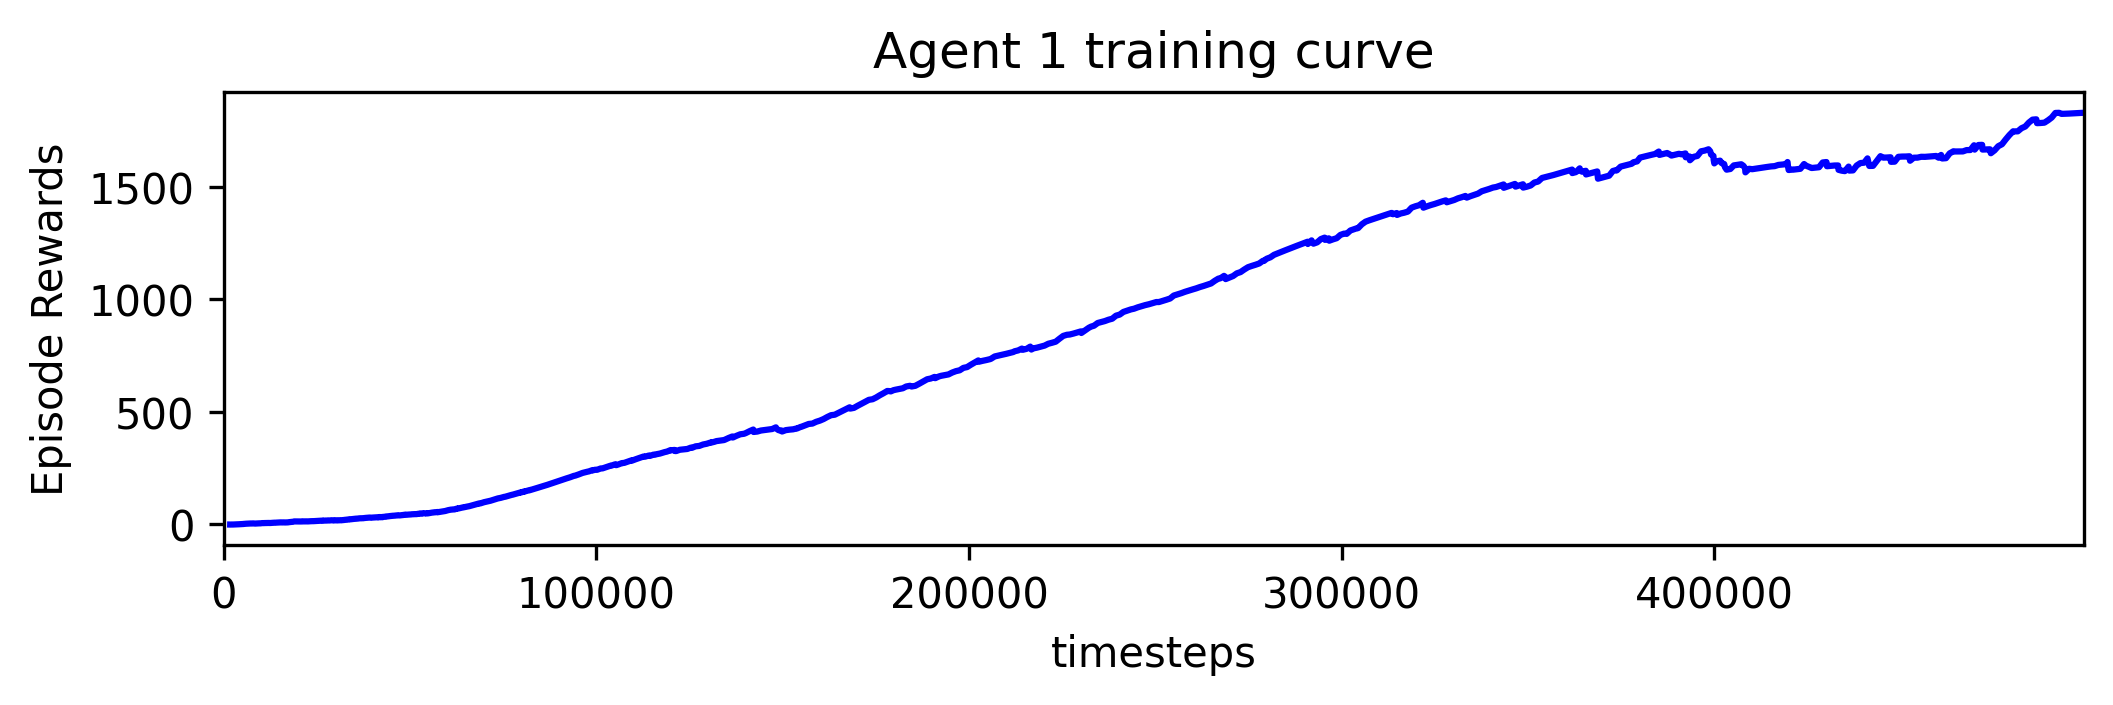

In [ ]:
log_dir = '../content/agent1/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

model_one = PPO('MlpPolicy', env, verbose=1, seed=1)
timesteps = 5e5
model_one.learn(total_timesteps=timesteps)

plot_training_curve([log_dir], timesteps, results_plotter.X_TIMESTEPS, "Agent 1 training curve")
plt.show()

## Get layer weights of policy net

In [ ]:
policy_weights = get_weights(model_one, net='policy')

Get weights of action net (i.e. actor layer of the policy).

In [ ]:
action_weights = get_weights(model_one, net='action')
policy_weights.append(action_weights[0])

policy_weights_all = [policy_weights]
print([layer.shape for layer in policy_weights])

[(64, 26), (64, 64), (6, 64)]


# Test agent

Test on separate evaluation environment.

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

def plot_rewards(mean_reward, title=None):
    plt.figure(figsize=(10,5), dpi=300)
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Rewards at episode')
    plt.xticks(list(range(1, len(mean_reward)+1)))
    plt.plot(list(range(1, len(mean_reward)+1)), mean_reward, marker='o')
    plt.show()

WalkerBase::__init__


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean reward=2367.68 +/- 272.32


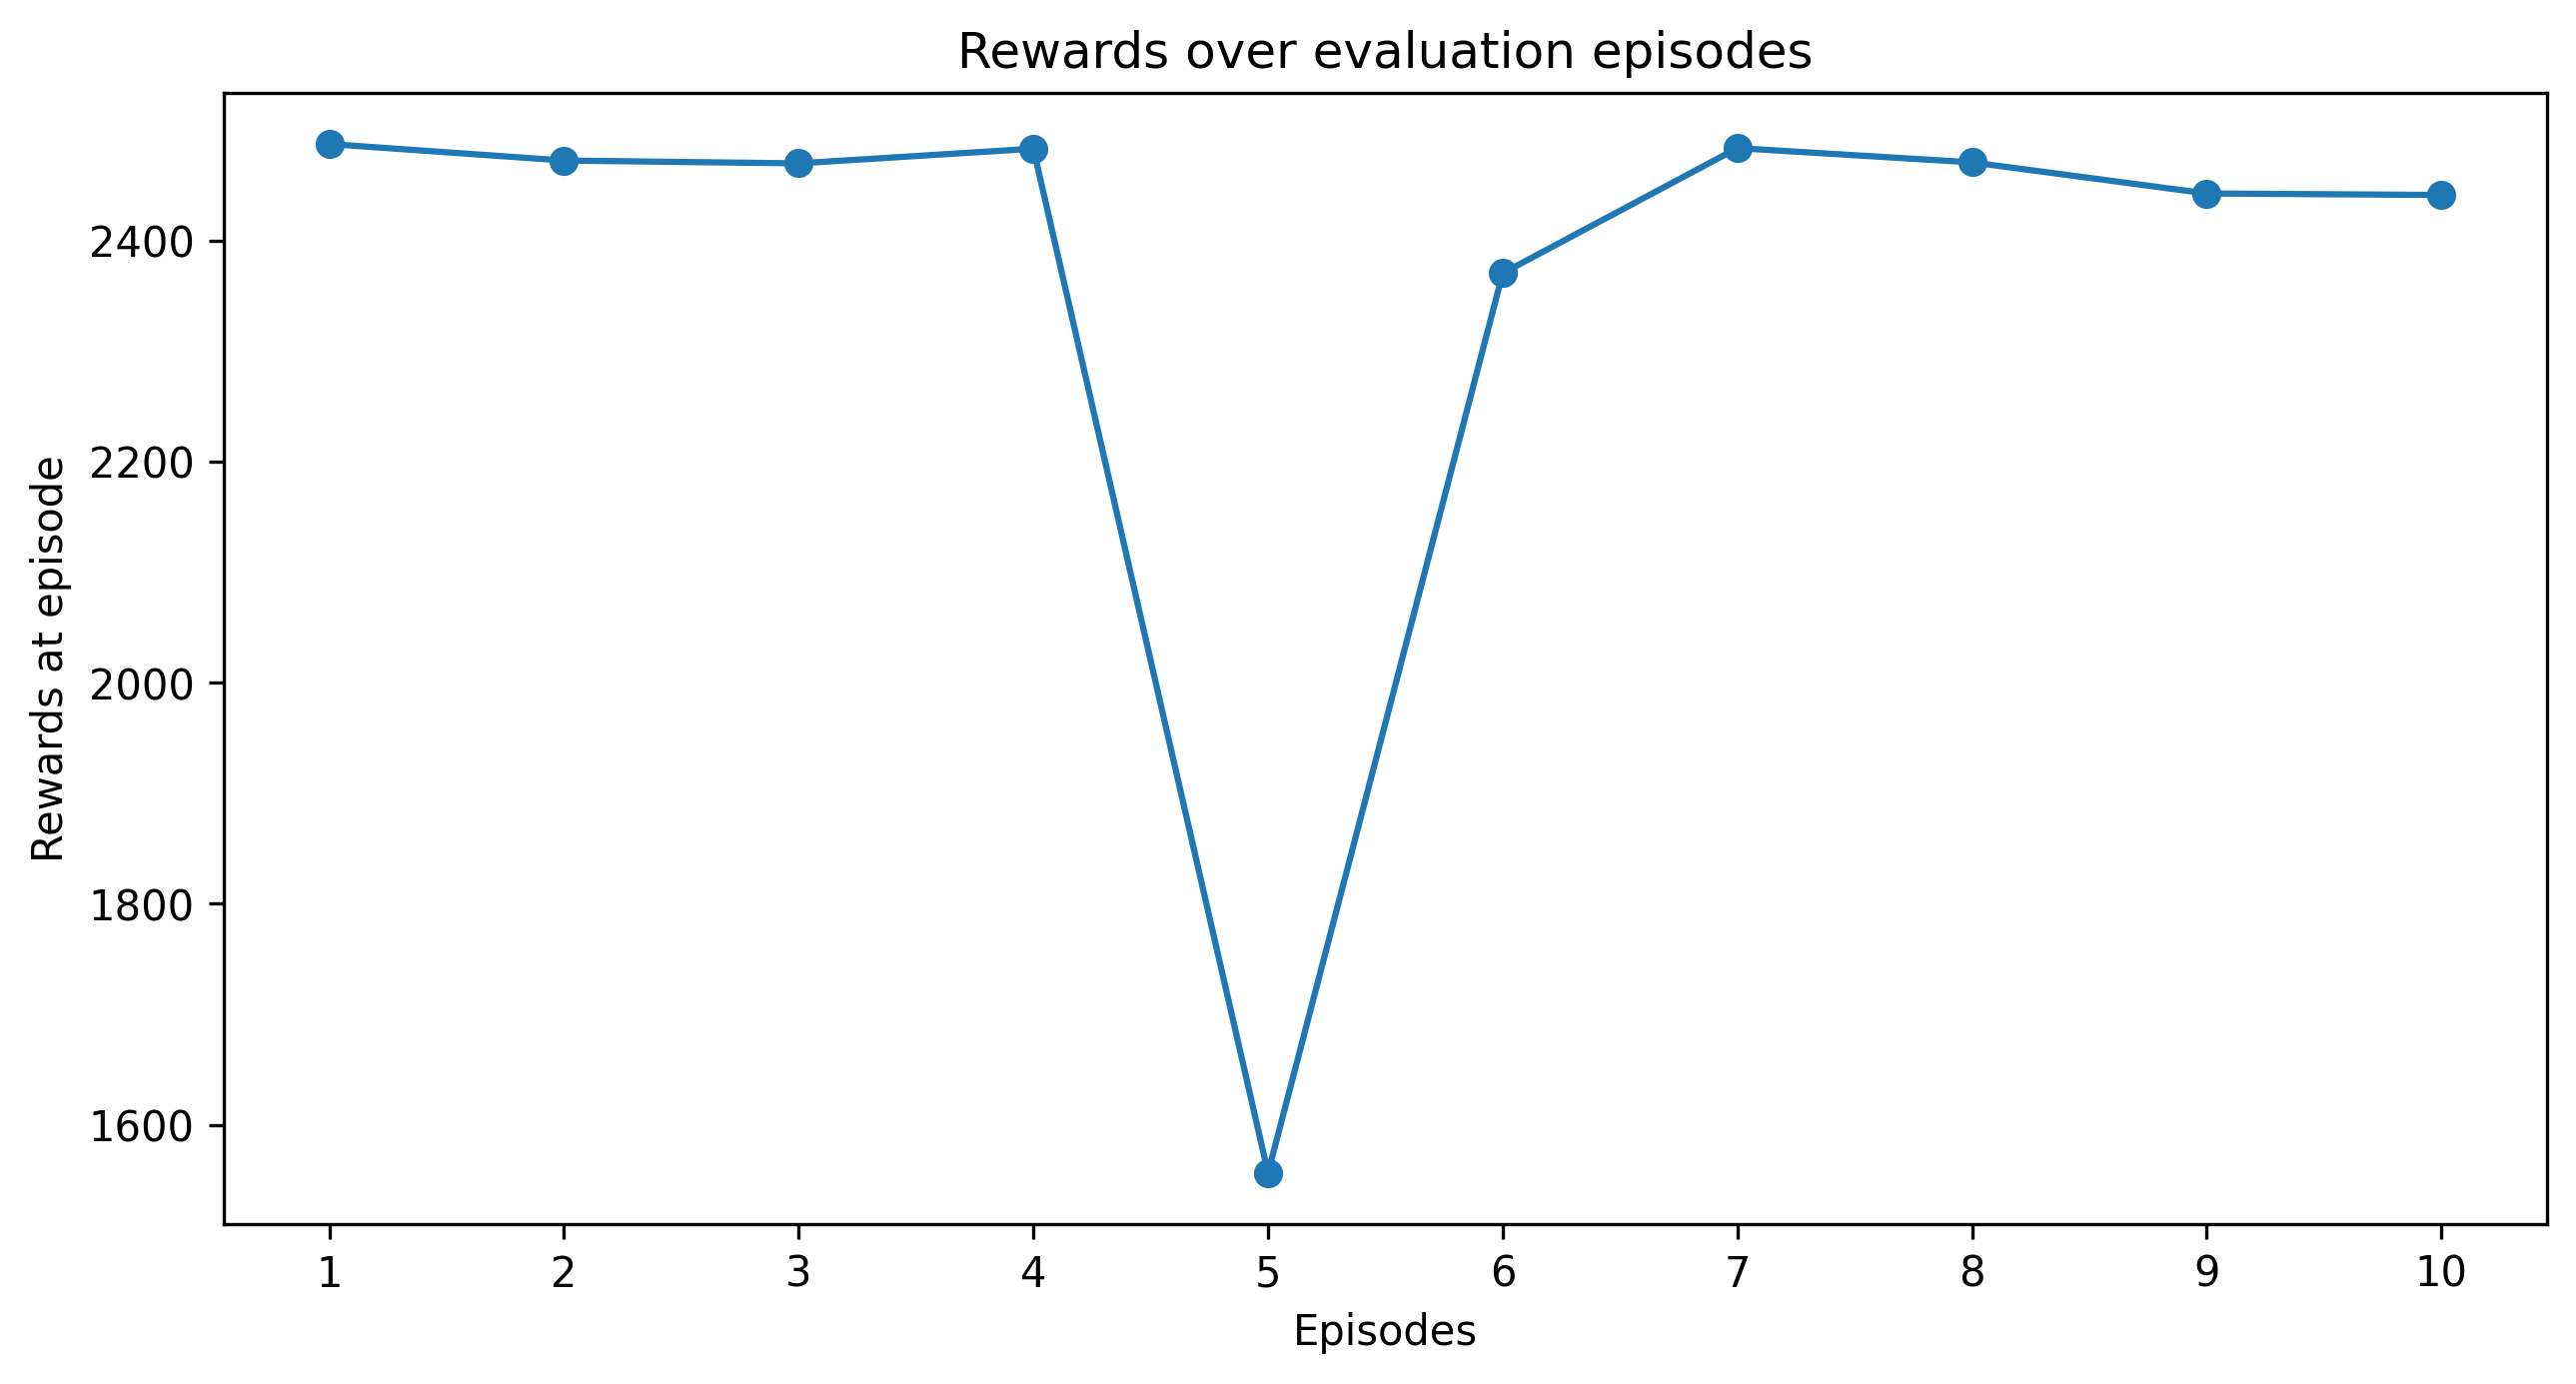

In [ ]:
# Create separate evaluation environment
eval_env = gym.make('HalfCheetahPyBulletEnv-v0')
overwrite_method(custom_thigh_power, eval_env)
eval_env.reset()

ep_rewards, ep_steps = evaluate_policy(model_one, eval_env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

Visualise the performance of the agent over a number of evaluation episodes.

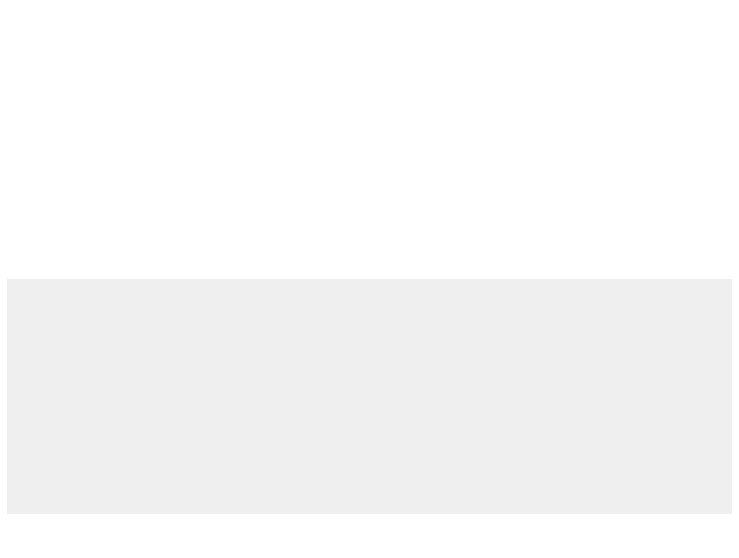

In [ ]:
os.makedirs('../content/agent1/rendering/', exist_ok=True)
render_agent_in_env(model_one, eval_env, n_eval_episodes=1, path='../content/agent1/rendering/', filename='agent1')

# Create second agent

This agent will be trained with greater foot strength.

In [ ]:
def custom_foot_power(robot, __p):

    WalkerBase.robot_specific_reset(robot, __p)

    robot.jdict["bthigh"].power_coef = 60.0
    robot.jdict["bshin"].power_coef  = 60.0
    robot.jdict["bfoot"].power_coef  = 70.0

    robot.jdict["fthigh"].power_coef = 80.0
    robot.jdict["fshin"].power_coef  = 30.0
    robot.jdict["ffoot"].power_coef  = 40.0

In [ ]:
env = gym.make('HalfCheetahPyBulletEnv-v0')
overwrite_method(custom_foot_power, env)
env.reset()

WalkerBase::__init__


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.29049525,  0.        ,
        0.01650923,  0.        , -0.3926868 ,  0.        ,  0.33693394,
        0.        , -0.03127963,  0.        ,  1.2596519 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ], dtype=float32)

Create another agent and train it on the different environment.

Streaming output truncated to the last 5000 lines.
|    loss                 | 10.9        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0139     |
|    std                  | 0.837       |
|    value_loss           | 18.8        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 57.4        |
|    ep_rew_mean          | 48.7        |
| time/                   |             |
|    fps                  | 436         |
|    iterations           | 19          |
|    time_elapsed         | 89          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.013730944 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.43       |
|    explained_variance   | 0.887       |
|    learning_rate        | 0.0003      |
|    loss                

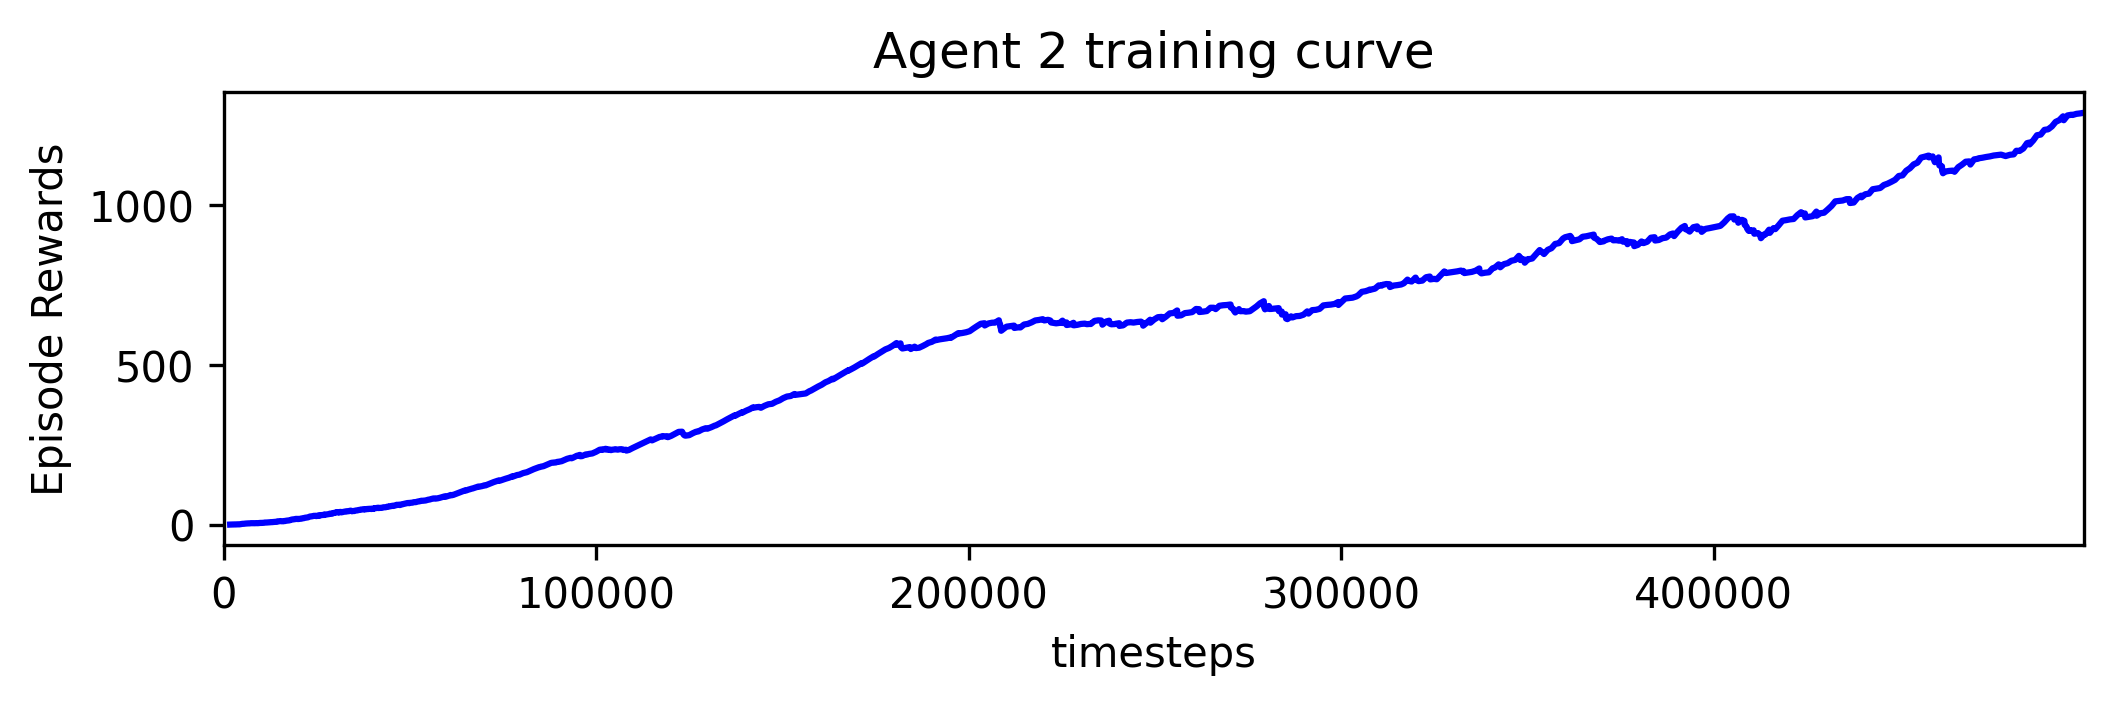

In [ ]:
log_dir = '../content/agent2/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

model_two = PPO('MlpPolicy', env, verbose=1, seed=1)
timesteps = 5e5
model_two.learn(total_timesteps=timesteps)

plot_training_curve([log_dir], timesteps, results_plotter.X_TIMESTEPS, "Agent 2 training curve")
plt.show()

Get layer weights of policy net and action net.

In [ ]:
policy_weights = get_weights(model_two, net='policy')
action_weights = get_weights(model_two, net='action')
policy_weights.append(action_weights[0])

policy_weights_all.append(policy_weights)
print([layer.shape for layer in policy_weights])

[(64, 26), (64, 64), (6, 64)]


Test second agent on a separate evaluation environment.

WalkerBase::__init__


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean reward=1847.61 +/- 6.51


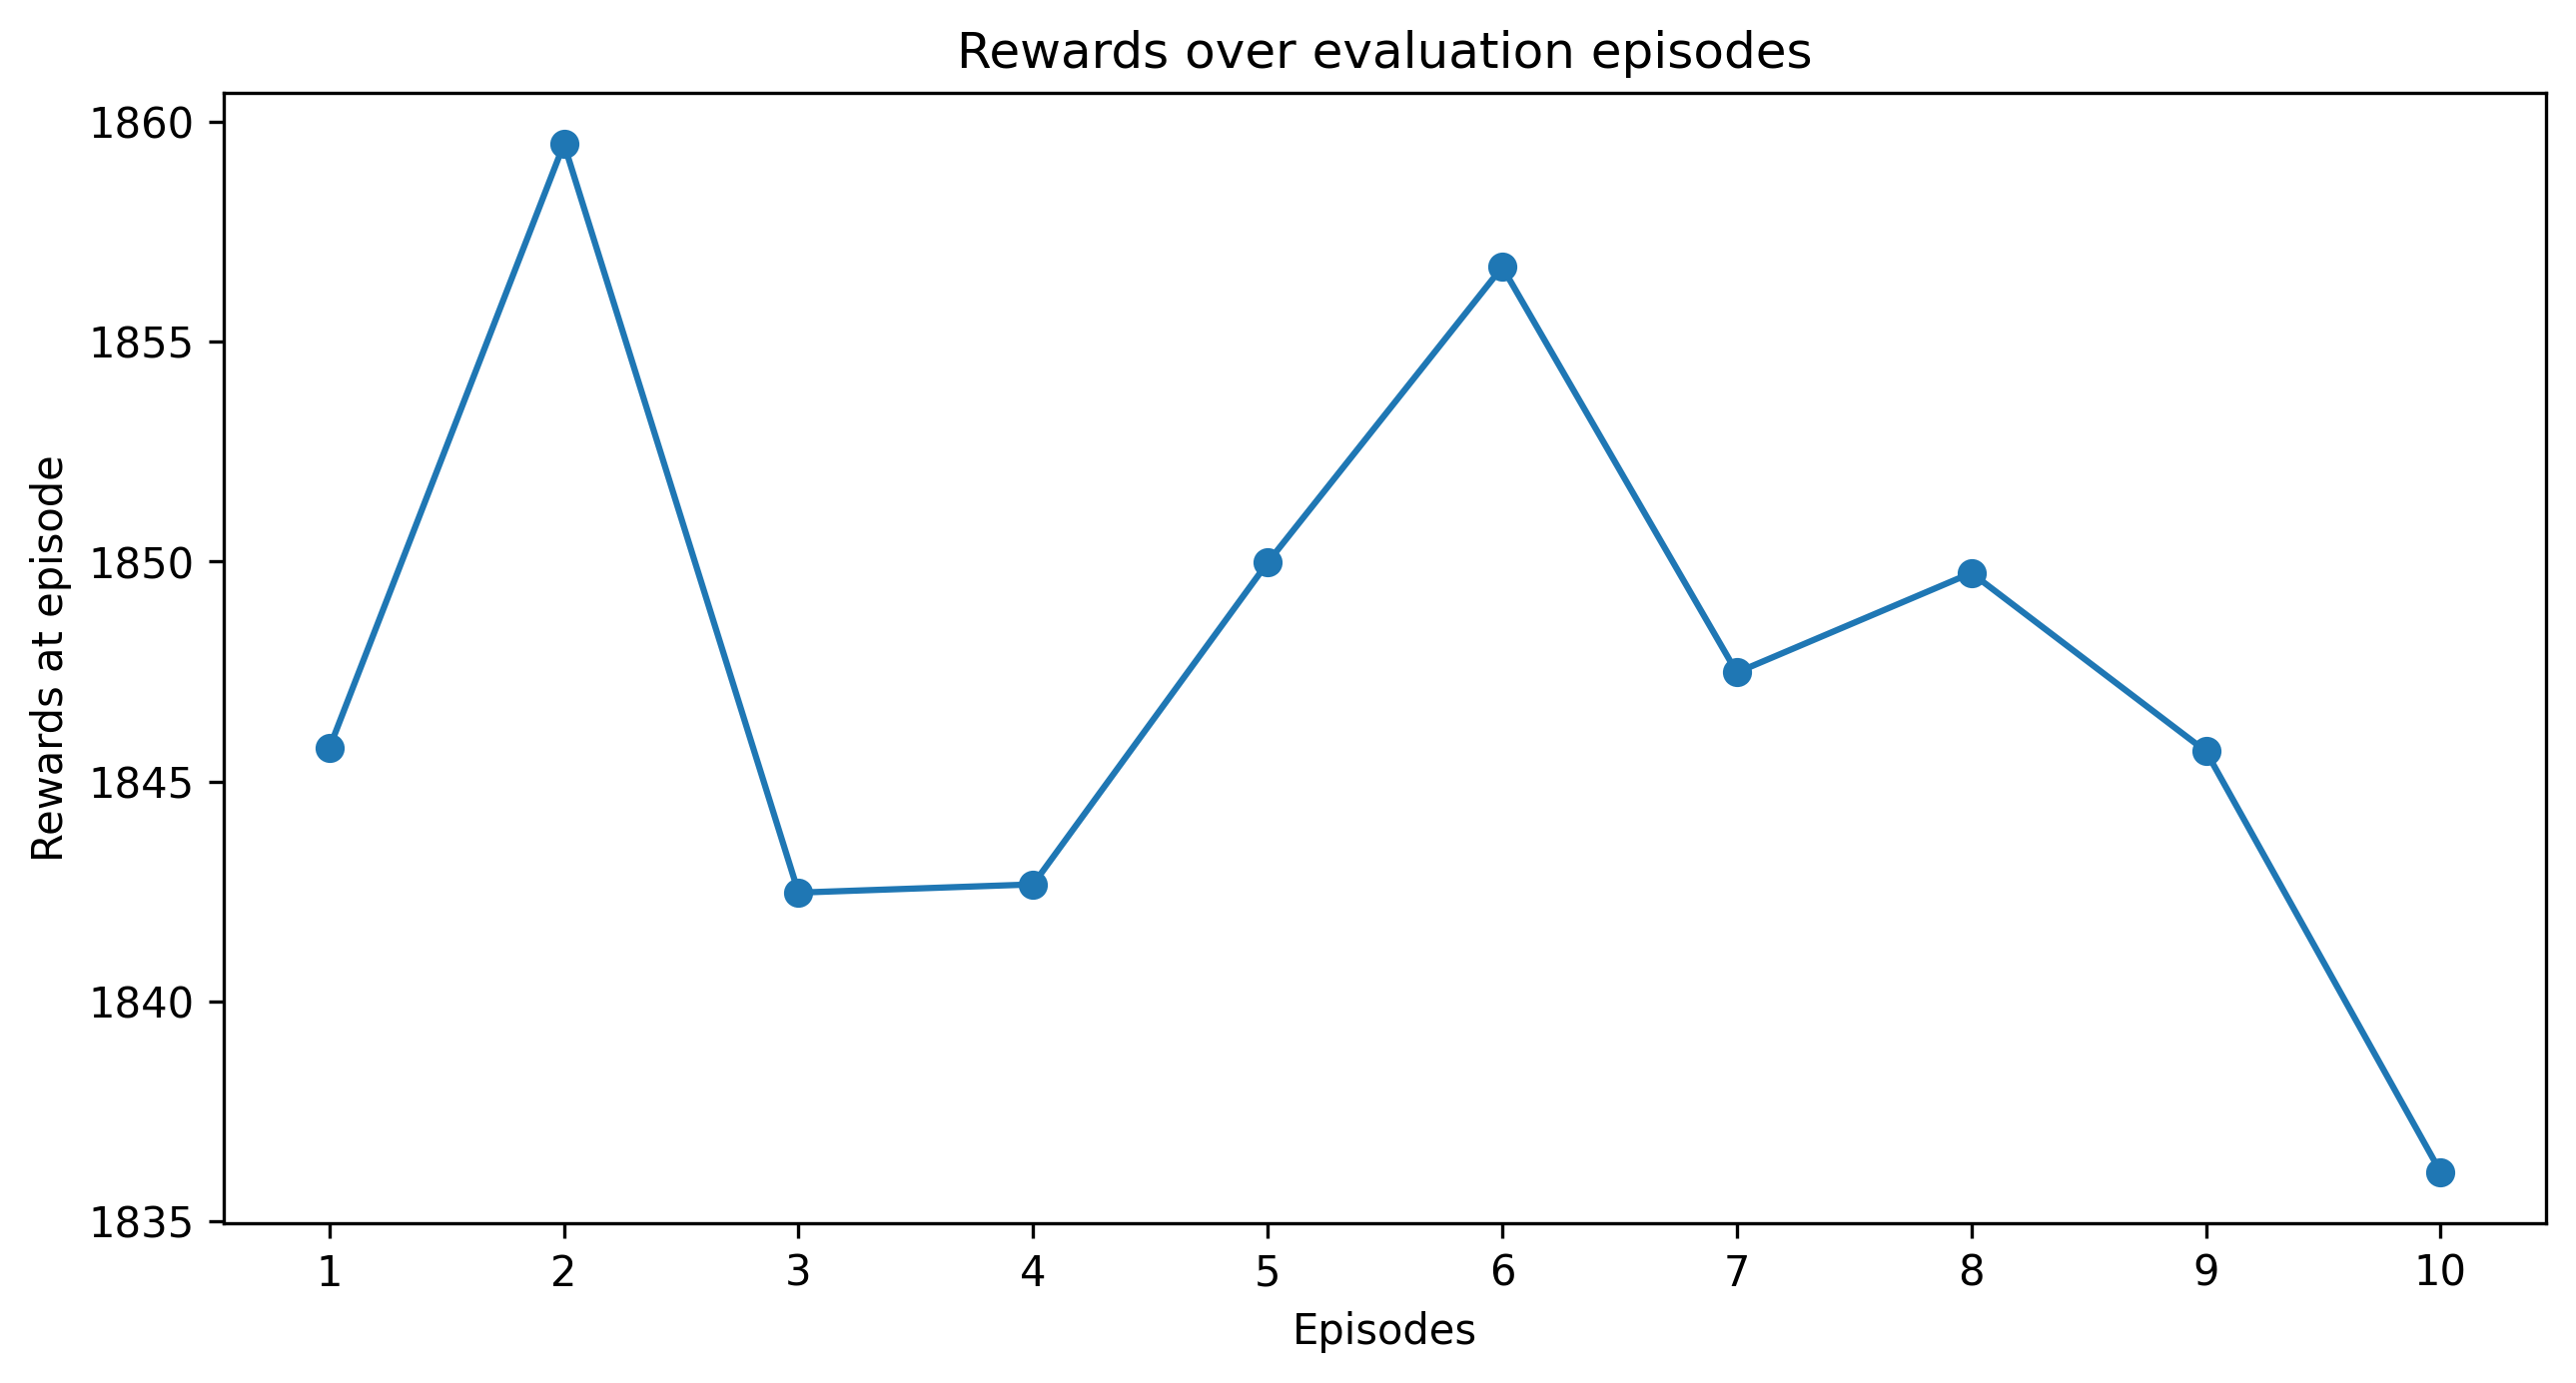

In [ ]:
# Create separate evaluation environment
eval_env = gym.make('HalfCheetahPyBulletEnv-v0')
overwrite_method(custom_foot_power, eval_env)
eval_env.reset()

ep_rewards, ep_steps = evaluate_policy(model_two, eval_env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

Visualise the performance of the agent over a number of evaluation episodes.

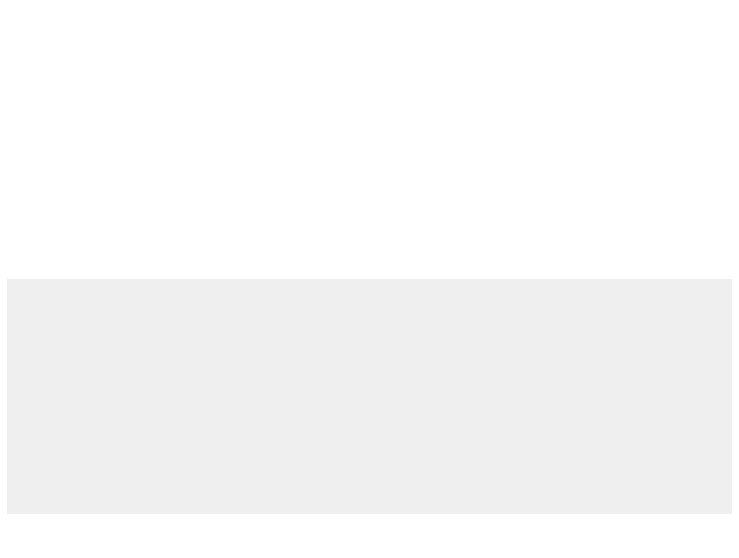

In [ ]:
os.makedirs('../content/agent2/rendering/', exist_ok=True)
render_agent_in_env(model_two, eval_env, n_eval_episodes=1, path='../content/agent2/rendering/', filename='agent2')

# Fuse the agents

## Align layers using OT

Compute the OT transport map between the weights, then align the matching nodes to each other using this map.

In [ ]:
import ot

def align_nodes(layer_weights_all, stop_layer_k=3):
    
    # Compute layer-wise transport maps
    for i in range(stop_layer_k):

        # Align other nets (source) to first net (target)
        for j in range(1, len(layer_weights_all)):
            Xs = layer_weights_all[j][i]
            Xt = layer_weights_all[0][i]

            # Reorganise source weights according to previous layer alignment
            if i > 0:
              for pos, w in enumerate(Xs):
                Xs[pos] = w[alignment_idx]

            # Compute optimal transport map using EMD, since matching whole nodes
            ot_emd = ot.da.EMDTransport()
            ot_emd.fit(Xs=Xs, Xt=Xt)

            # Get source net aligned to node positions of target net
            aligned_Xs = ot_emd.inverse_transform(Xt=Xt)

            # Replace original with aligned 
            layer_weights_all[j][i] = aligned_Xs

            # Save as previous layer alignment
            alignment_idx = []
            for w in range(Xs.shape[0]):
              idx = np.argwhere(aligned_Xs == Xs[w])[0][0]
              alignment_idx.append(idx)

    return layer_weights_all

aligned_policy_weights_all = align_nodes(policy_weights_all, stop_layer_k=3)

## Average weights
Average layer weights to fuse the aligned neurons.

In [ ]:
def fuse_policy_weights(aligned_policy_weights_all):
    sum_weights = [np.add(aligned_policy_weights_all[0][0], 
                          aligned_policy_weights_all[1][0]), 
                   np.add(aligned_policy_weights_all[0][1], 
                          aligned_policy_weights_all[1][1]),
                   np.add(aligned_policy_weights_all[0][2],
                          aligned_policy_weights_all[1][2])]
    return [layer/2 for layer in sum_weights]

fused_policy_weights = fuse_policy_weights(aligned_policy_weights_all)

# Evaluate the fused model

We will evaluate the performance of the fused model on an agent with neutral power for both thighs and feet.

In [ ]:
def custom_netural_power(robot, __p):

    WalkerBase.robot_specific_reset(robot, __p)

    robot.jdict["bthigh"].power_coef = 120.0
    robot.jdict["bshin"].power_coef  = 90.0
    robot.jdict["bfoot"].power_coef  = 60.0

    robot.jdict["fthigh"].power_coef = 140.0
    robot.jdict["fshin"].power_coef  = 60.0
    robot.jdict["ffoot"].power_coef  = 30.0

# Create separate evaluation environment
eval_env = gym.make('HalfCheetahPyBulletEnv-v0')
overwrite_method(custom_netural_power, eval_env)
eval_env.reset()

WalkerBase::__init__


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.42298597,  0.        ,
       -0.05673631,  0.        , -0.33911088,  0.        ,  0.33769932,
        0.        , -0.03018827,  0.        ,  1.1946979 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ], dtype=float32)

In [ ]:
def replace_policy(model, new_policy, new_actor):

    # Replace policy net with given policy
    policy = model.get_parameters().get('policy')
    policy['mlp_extractor.policy_net.0.weight'] = pt.from_numpy(new_policy[0])
    policy['mlp_extractor.policy_net.2.weight'] = pt.from_numpy(new_policy[1])
    policy['action_net.weight'] = pt.from_numpy(new_actor)
    updated_param = {'policy': policy}

    # Set policy parameter 
    model.set_parameters(updated_param, exact_match=False)
    return model


env = gym.make('HalfCheetahPyBulletEnv-v0')
overwrite_method(custom_netural_power, env)
env.reset()

# Make a new model from fused layers
log_dir = '../content/fused/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

fused_model = PPO('MlpPolicy', env, verbose=1, seed=1)
new_policy = fused_policy_weights[:-1]
new_actor = fused_policy_weights[-1]
fused_model = replace_policy(fused_model, new_policy, new_actor)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


WalkerBase::__init__
Using cpu device
Wrapping the env in a DummyVecEnv.


## Without retraining

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean reward=729.85 +/- 307.28


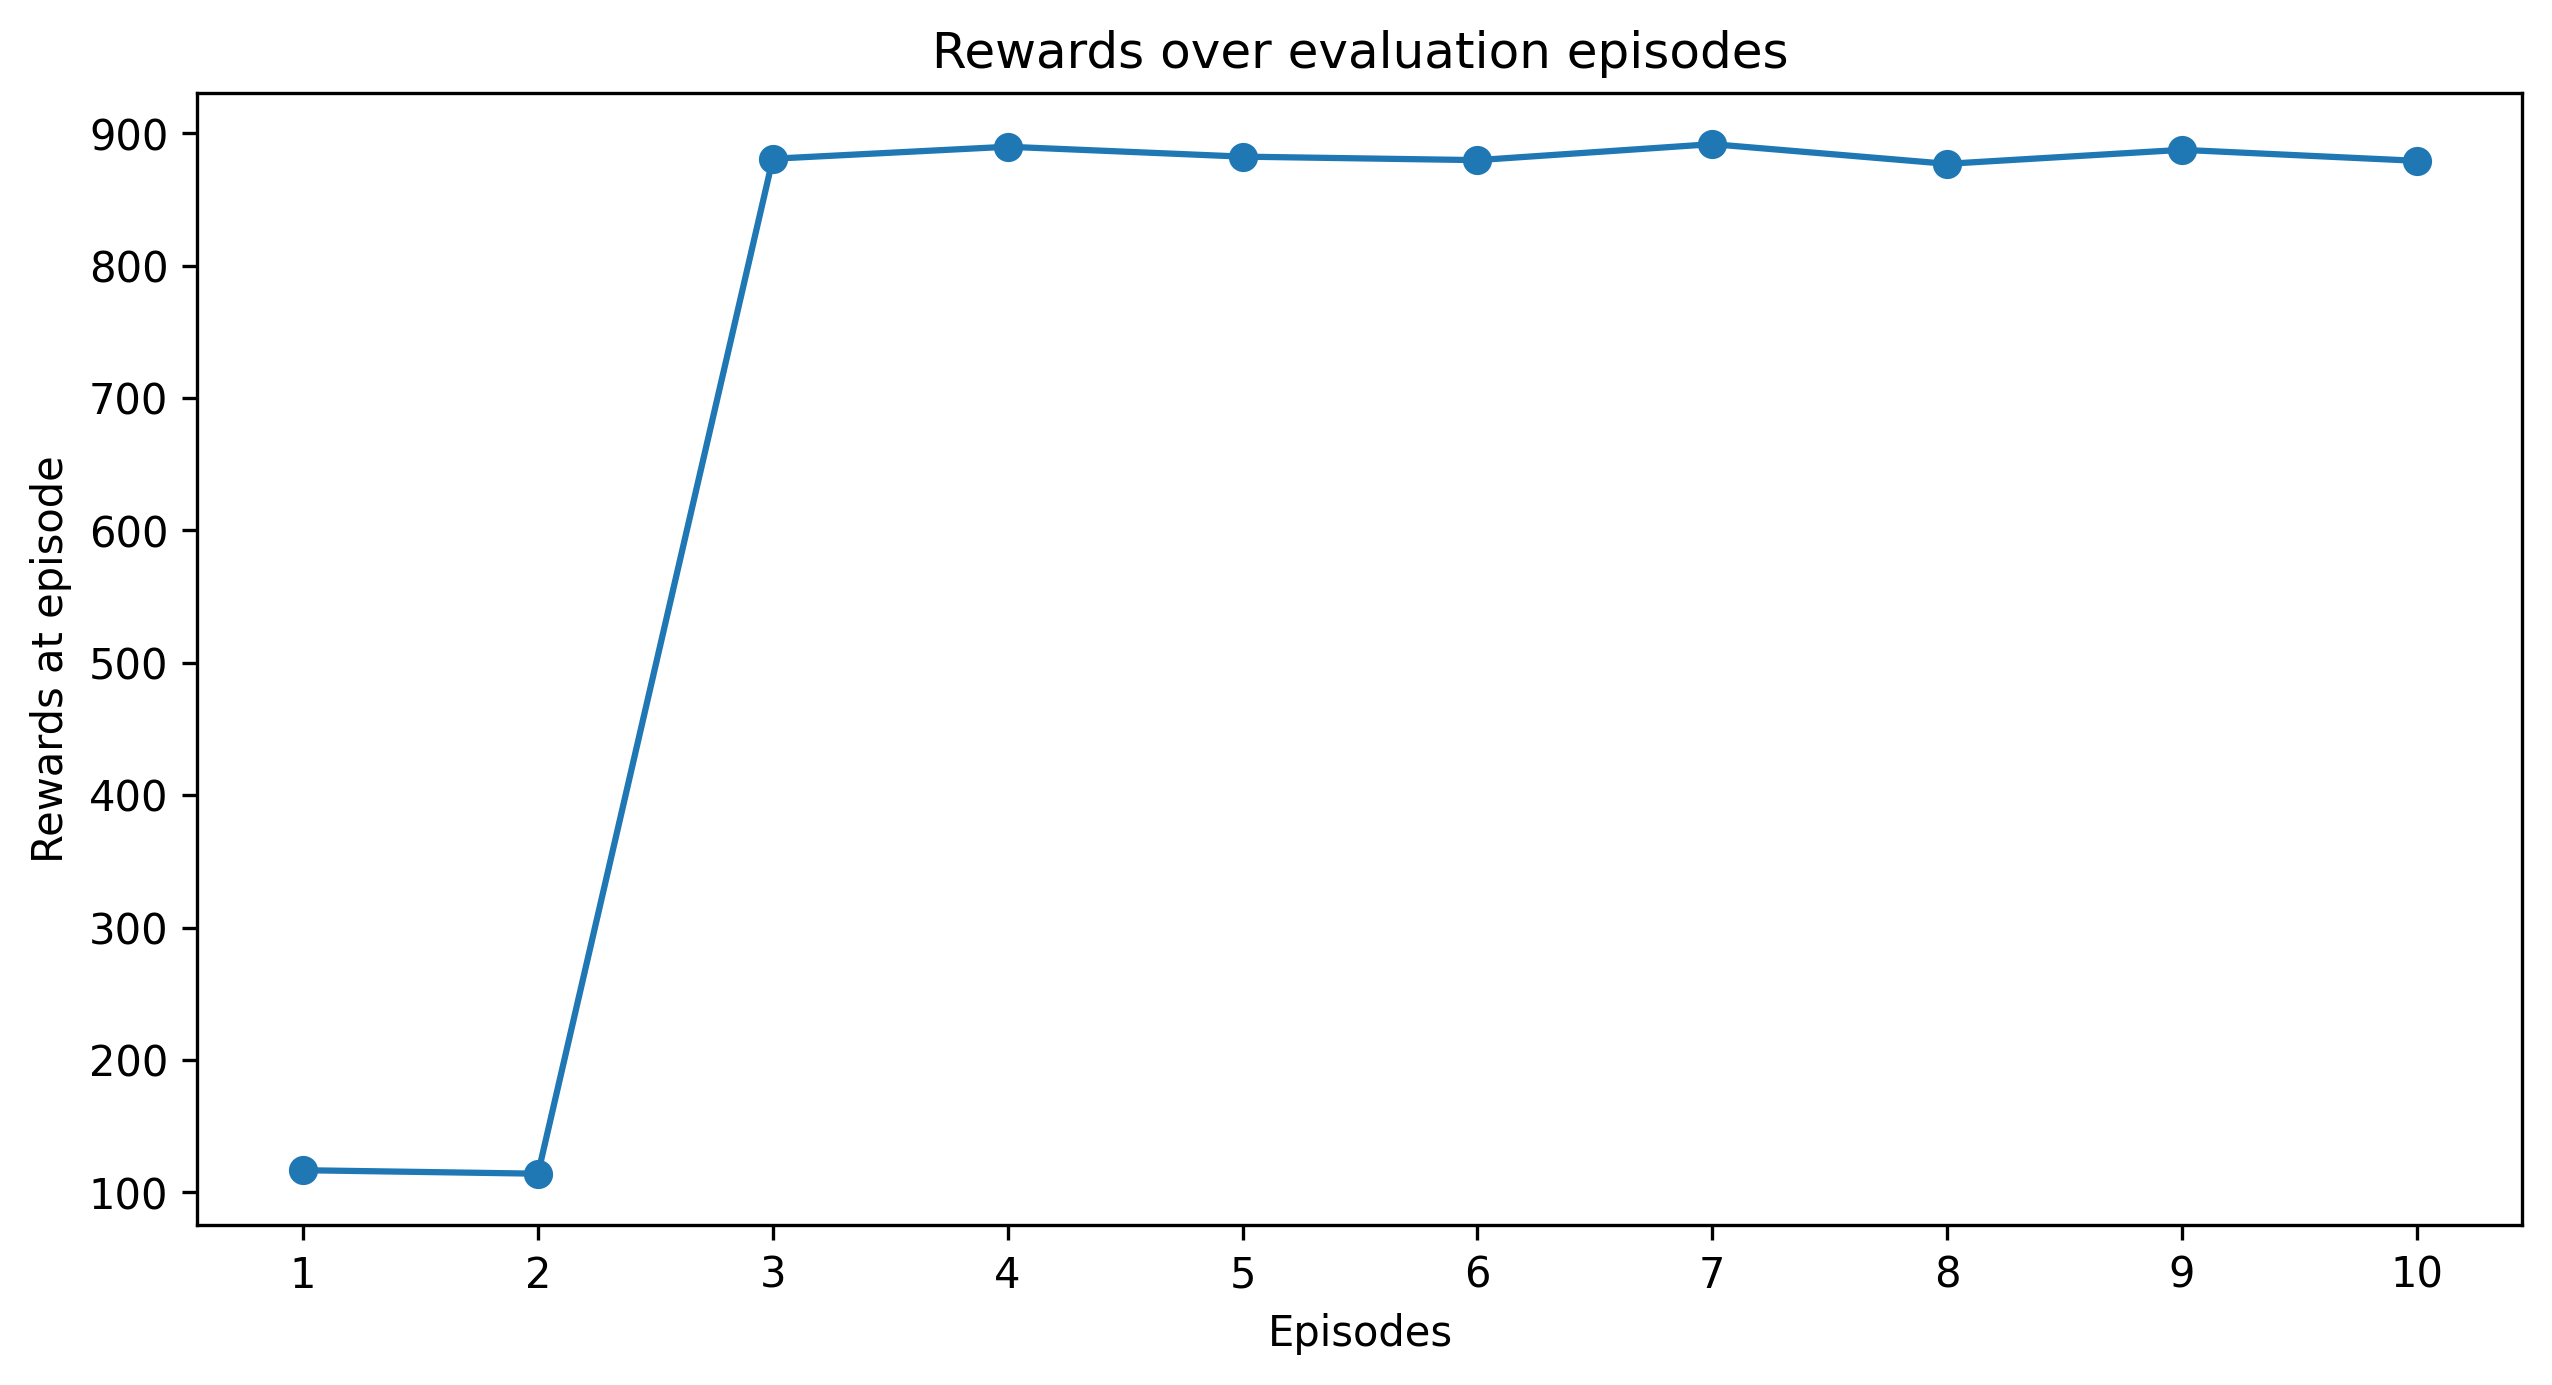

In [ ]:
ep_rewards, ep_steps = evaluate_policy(fused_model, eval_env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

In [ ]:
os.makedirs('../content/fused/rendering/', exist_ok=True)
render_agent_in_env(fused_model, eval_env, n_eval_episodes=1, path='../content/fused/rendering/', filename='untrained')

## With retraining

Retrain fused model to optimise weights.

In [ ]:
timesteps = 5e5
fused_model.learn(total_timesteps=timesteps)

Streaming output truncated to the last 5000 lines.
|    loss                 | 6.18       |
|    n_updates            | 170        |
|    policy_gradient_loss | -0.0166    |
|    std                  | 0.904      |
|    value_loss           | 12.4       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 297         |
|    ep_rew_mean          | 217         |
| time/                   |             |
|    fps                  | 447         |
|    iterations           | 19          |
|    time_elapsed         | 86          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.016773622 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.88       |
|    explained_variance   | 0.786       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.1

Compare to retraining original models.

In [ ]:
env = gym.make('HalfCheetahPyBulletEnv-v0')
overwrite_method(custom_netural_power, env)
env.reset()

log_dir = '../content/agent1/retraining/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

model_one.set_env(env)
timesteps = 5e5
model_one.learn(total_timesteps=timesteps)

In [ ]:
env = gym.make('HalfCheetahPyBulletEnv-v0')
overwrite_method(custom_netural_power, env)
env.reset()

log_dir = '../content/agent2/retraining/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

model_two.set_env(env)
timesteps = 5e5
model_two.learn(total_timesteps=timesteps)

Compare to training model from scratch.

In [ ]:
env = gym.make('HalfCheetahPyBulletEnv-v0')
overwrite_method(custom_netural_power, env)
env.reset()

log_dir = '../content/new-agent/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

new_model = PPO('MlpPolicy', env, verbose=1, seed=1)
timesteps = 5e5
new_model.learn(total_timesteps=timesteps)

Plot all training curves on the same axes.

In [ ]:
all_dirs = ['../content/new-agent/results/', '../content/fused/results/', '../content/agent1/retraining/results/', '../content/agent2/retraining/results']
legend = ['new agent', 'fused agent', 'original agent 1', 'original agent 2']
plot_training_curve(all_dirs, timesteps, results_plotter.X_TIMESTEPS, "Agents retraining with neutral leg power", legend=legend)

## Evaluation and rendering

Fused model:

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean reward=2332.19 +/- 1113.37


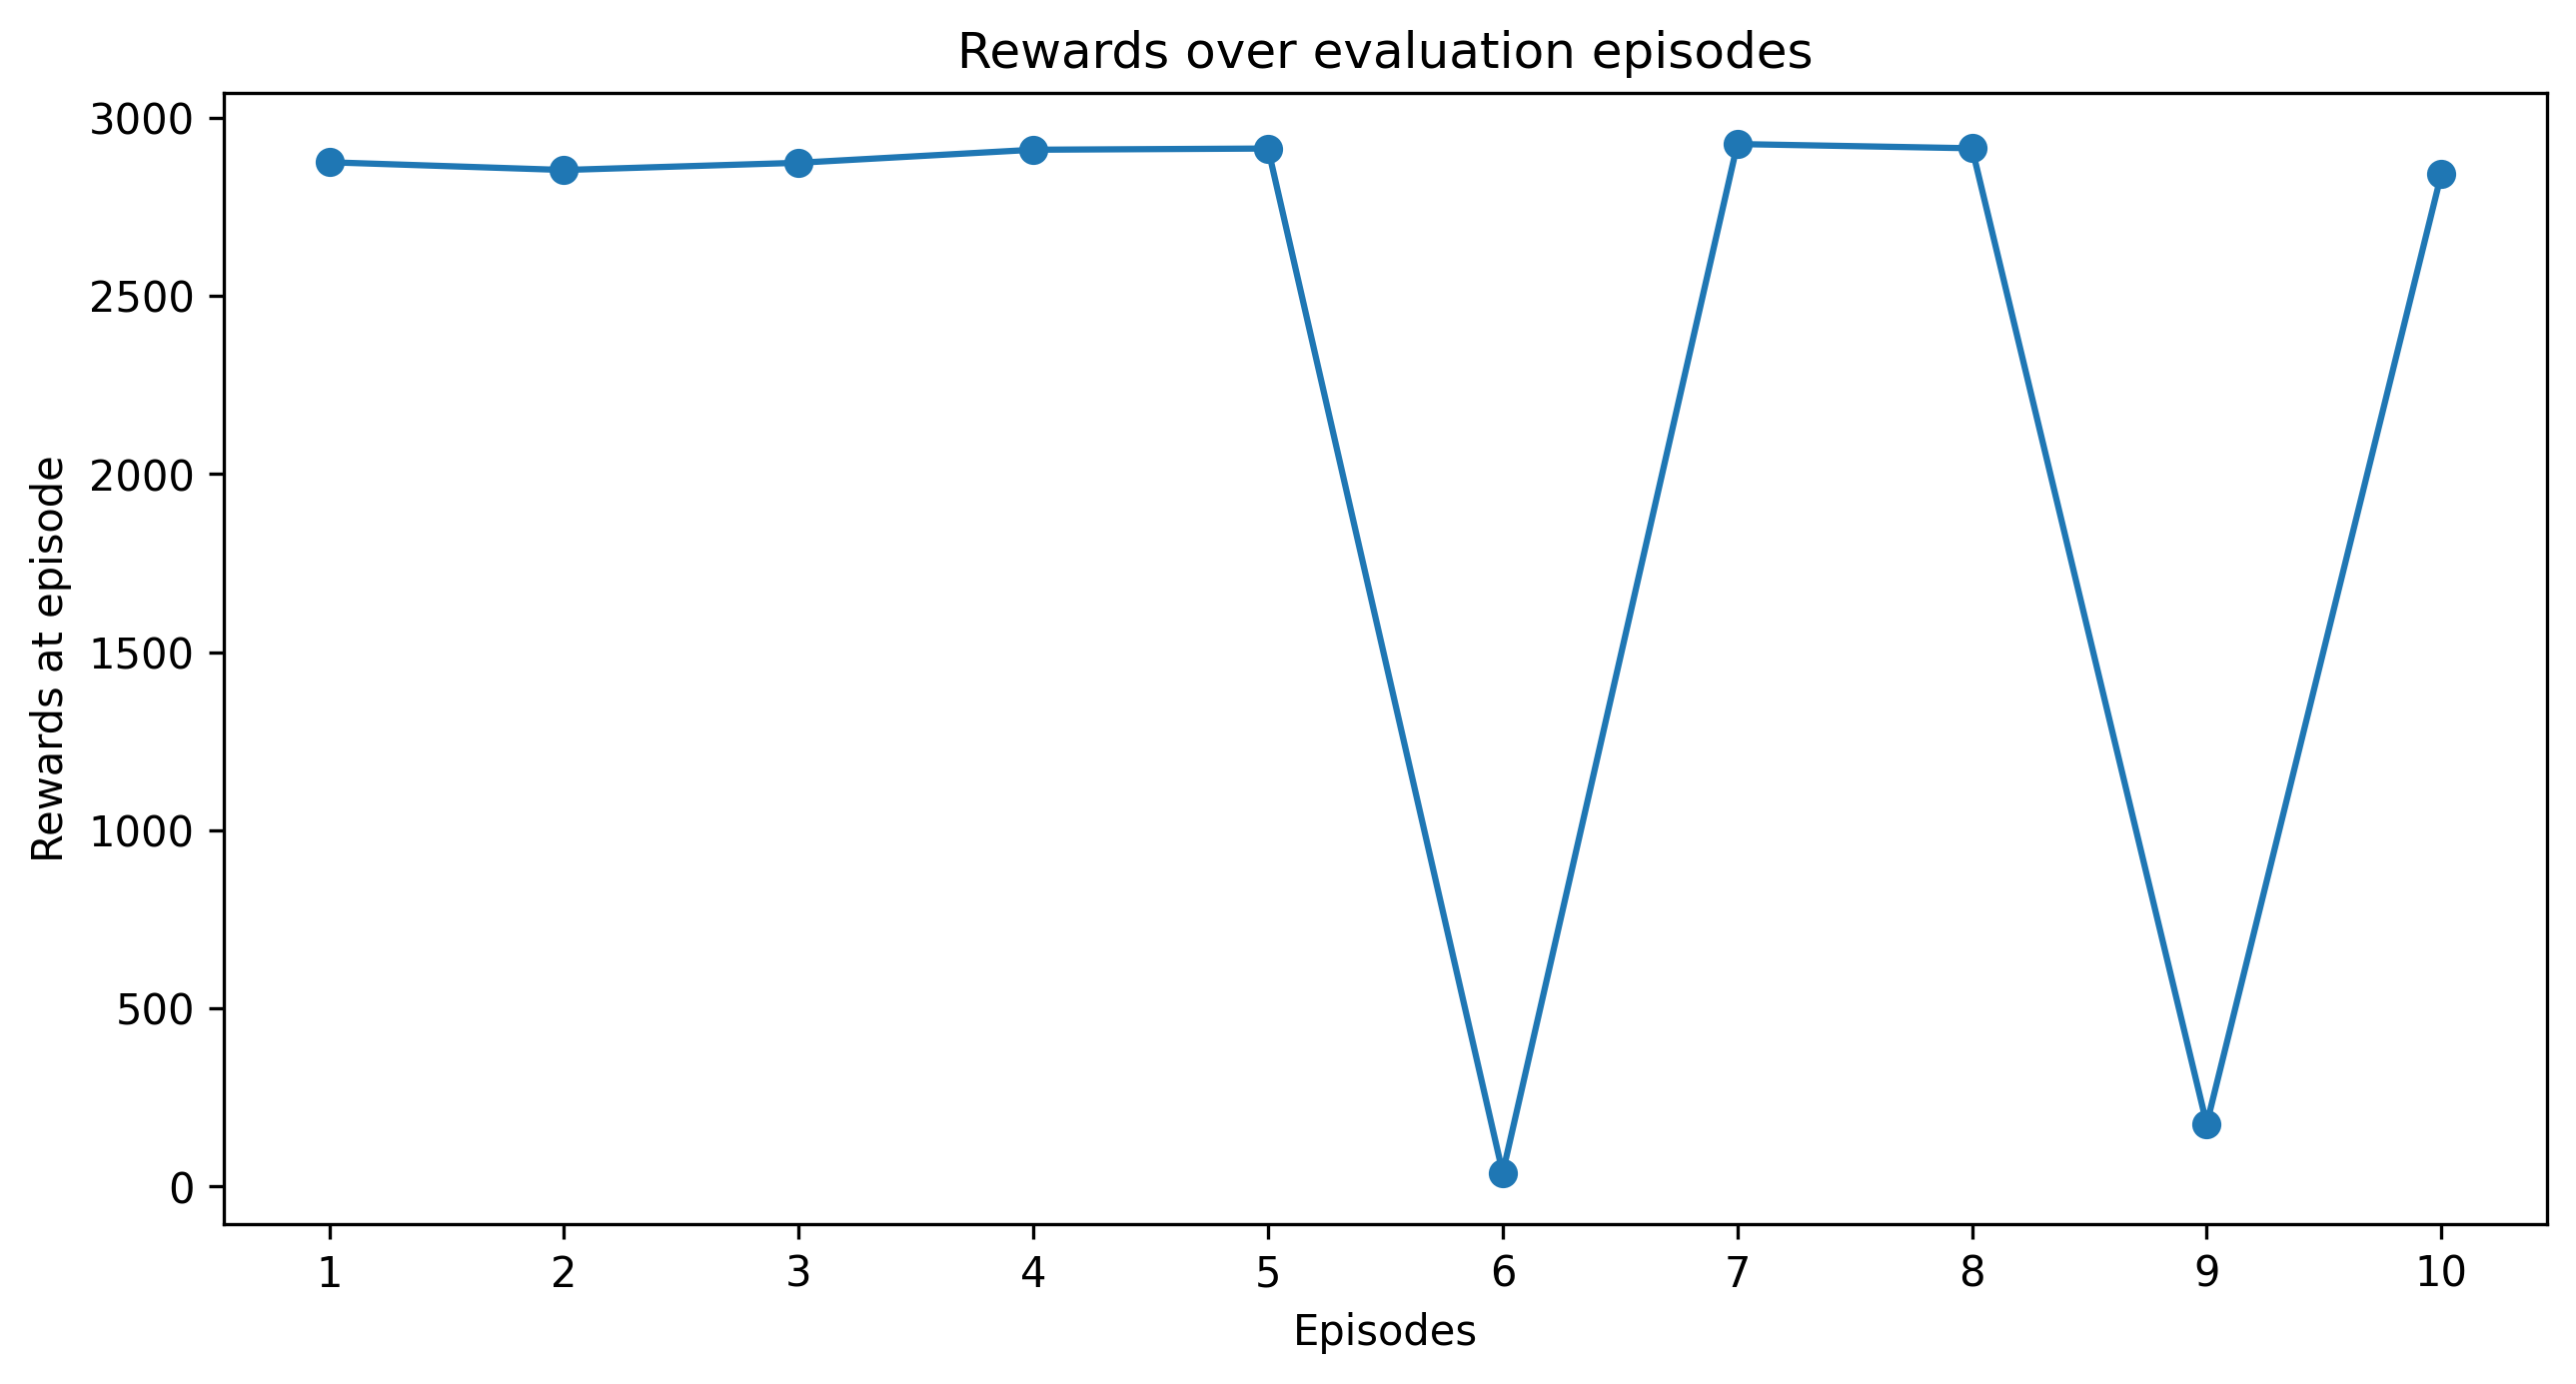

In [ ]:
ep_rewards, ep_steps = evaluate_policy(fused_model, eval_env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

In [ ]:
os.makedirs('../content/fused/rendering/', exist_ok=True)
render_agent_in_env(fused_model, eval_env, n_eval_episodes=1, path='../content/fused/rendering/', filename='retrained')

New model:

In [ ]:
ep_rewards, ep_steps = evaluate_policy(new_model, eval_env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

In [ ]:
os.makedirs('../content/new-agent/rendering/', exist_ok=True)
render_agent_in_env(new_model, eval_env, n_eval_episodes=1, path='../content/new-agent/rendering/', filename='new-agent')

Retrained agent 1:

In [ ]:
ep_rewards, ep_steps = evaluate_policy(model_one, eval_env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

In [ ]:
os.makedirs('../content/agent1/retraining/rendering/', exist_ok=True)
render_agent_in_env(model_one, eval_env, n_eval_episodes=1, path='../content/agent1/retraining/rendering/', filename='agent1-retrained')

Retrained agent 2:

In [ ]:
ep_rewards, ep_steps = evaluate_policy(model_two, eval_env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

In [ ]:
os.makedirs('../content/agent2/retraining/rendering/', exist_ok=True)
render_agent_in_env(model_two, eval_env, n_eval_episodes=1, path='../content/agent2/retraining/rendering/', filename='agent2-retrained')